In [187]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

auc_pairs={}
auc_pairs_train={}


def plot_rocs(pairs):
    for name, (fpr, tpr, roc_auc) in pairs.items(): 
        plt.plot(fpr, tpr, label = F"{name}: area {roc_auc:0.3f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
    
    plt.legend(loc="lower right")
    plt.show()


'''important:
    In sklearn implementation that [0,0] of confusion matrix is TN, which is very counter intuitive.
    Therefore, to get [0,0] as TP, I did confusion_matrix(..., labels=[1,0]). Then, in my notation 1 is "positive", 
    and the output of this confusion_matrix will give me [0,0] as TP.

'''

def measure(mat): 
    #mat = cm_train[name]
    TP,FN = mat[0,0],mat[0,1]
    FP,TN = mat[1,0],mat[1,1]

    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)

    f1 = (2*recall*precision)/(recall+precision)


    return {"recall":recall, 
            "precision":precision, 
            "f1":f1}

In [188]:
from IPython.core.debugger import set_trace
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

# -- for grid 2d plot
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# -- for 3d plot 
#from mpl_toolkits.mplot3d import Axes3Dx
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

# -- for models
from importlib import reload


# -- for AUC and metrics: 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def plot(model,axis=None, show_=True, scoreplot = False):
    x1 = arange(*x1_range,1711)
    x2 = arange(*x2_range,5)
    X1, X2 = meshgrid(x1, x2) # grid of point
    tX1 = torch.from_numpy(X1).to(device).view(-1,1).float()
    tX2 = torch.from_numpy(X2).to(device).view(-1,1).float()

    data = torch.cat([tX1,tX2,torch.zeros(tX2.shape[0],15).to(device)], dim=1)
    #set_trace()
    #score = model(tX1,tX2).detach().clone().to("cpu").view(*X1.shape)
    score = model(data).detach().clone().to("cpu").view(*X1.shape)
    if scoreplot: 
        Z = score.numpy()
    else: 
        Z = 1/(1+(-score).exp()).numpy()
    
    if axis: 
        im = axis.imshow(np.flip(Z, axis = 0),cmap=cm.RdBu) # drawing the function
    else:    
        im = imshow(np.flip(Z, axis = 0),cmap=cm.RdBu) # drawing the function
    if not scoreplot: im.set_clim(0,1)
    # adding the Contour lines with labels
    #cset = contour(Z,arange(-10,150,5),linewidths=1,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im,ax = axis) # adding the colobar on the right
    # latex fashion title
    #title('$z=(1-x_1^2+x_2^3) e^{-(x^2+y^2)/2}$')
    if show_: show()

In [189]:
device="cuda"

In [190]:
X_train, Y_train= torch.load("/home/kim2712/Desktop/research/mono/data/mined_train.dat")
X_test,Y_test = torch.load("/home/kim2712/Desktop/research/mono/data/mined_test.dat")

In [191]:
x1_range = [X_train[:,0].min(),X_train[:,0].max()]
x2_range = [X_train[:,1].min(),X_train[:,1].max()]

x1_range, x2_range

([0.0, 1.0], [0.0, 1.0])

In [192]:
#nns.MonotonicNN_JK,  nns.MonotonicNN
#model_monotonic_JK =nns.MonotonicNN_JK(2, [100, 100, 100], nb_steps=500, dev=device,x0 = +x1_range[0]).to(device)
#optim_monotonic = torch.optim.Adam(model_monotonic.parameters(), 1e-3, weight_decay=1e-5)
#optim_mlp = torch.optim.Adam(model_mlp.parameters(), 1e-3, weight_decay=1e-5)

data = torch.from_numpy(X_train).to(device).float()
target = torch.from_numpy(Y_train).to(device).float()

data_test = torch.from_numpy(X_test).to(device).float()
target_test = torch.from_numpy(Y_test).to(device).float()

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
sigmoid = torch.nn.Sigmoid()# important!! If I use my own sigmoid, cuda error accurs..;;;

In [193]:
from xgboost import XGBClassifier
booster = XGBClassifier(max_depth = 5, use_label_encoder=False,
                        monotone_constraints=(-1, -1, -1,-1, +1,+1,+1,+1, +1, +1, +1))
booster.fit(X_train, (Y_train).astype(int))

y_pred_tr = booster.predict(X_train)

predictions_tr = [round(value) for value in y_pred_tr]

# evaluate predictions

accuracy_tr = accuracy_score(Y_train, predictions_tr)

print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

y_pred_test = booster.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]
accuracy_test = accuracy_score(Y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy_test * 100.0))

y_pred_tr = booster.predict_proba(X_test)
y_scores = y_pred_tr[:,1]
fpr, tpr, _ = roc_curve(Y_test, y_scores)
roc_auc = auc(fpr, tpr)
auc_pairs.update({"xgboost": (fpr, tpr, roc_auc) })

y_pred_tr = booster.predict_proba(X_train)
y_scores = y_pred_tr[:,1]
fpr, tpr, _ = roc_curve(Y_train, y_scores)
roc_auc = auc(fpr, tpr)
auc_pairs_train.update({"xgboost": (fpr, tpr, roc_auc) })

[10:15:25] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 95.77%
Test Accuracy: 93.43%


In [194]:
boost ={}
boost.update({"train":confusion_matrix(Y_train, predictions_tr,labels=[1,0])})
boost.update({"test":confusion_matrix(Y_test, predictions_test,labels=[1,0])})

stat_boost={}

for name, mat in boost.items():
    stat_boost.update({name:measure(mat)})
stat_boost["train"].update({"acc":accuracy_tr * 100.0})
stat_boost["test"].update({"acc":accuracy_test * 100.0})

In [195]:
scale_pos_weight = (Y_train==0).sum()/(Y_train==1).sum()
print("scale_pos_weight",scale_pos_weight)
booster = XGBClassifier(max_depth = 5, use_label_encoder=False,
                        monotone_constraints=(-1, -1, -1,-1, +1,+1,+1,+1, +1, +1, +1)
                        ,scale_pos_weight = scale_pos_weight)
booster.fit(X_train, (Y_train).astype(int))

y_pred_tr = booster.predict(X_train)

predictions_tr = [round(value) for value in y_pred_tr]

# evaluate predictions

accuracy_tr = accuracy_score(Y_train, predictions_tr)

print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

y_pred_test = booster.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]
accuracy_test = accuracy_score(Y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy_test * 100.0))


y_pred_tr = booster.predict_proba(X_test)
y_scores = y_pred_tr[:,1]
fpr, tpr, _ = roc_curve(Y_test, y_scores)
roc_auc = auc(fpr, tpr)
auc_pairs.update({"im_xgboost": (fpr, tpr, roc_auc) })

y_pred_tr = booster.predict_proba(X_train)
y_scores = y_pred_tr[:,1]
fpr, tpr, _ = roc_curve(Y_train, y_scores)
roc_auc = auc(fpr, tpr)
auc_pairs_train.update({"im_xgboost": (fpr, tpr, roc_auc) })

scale_pos_weight 11.353304508956146
[10:15:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 90.81%
Test Accuracy: 86.40%


In [196]:
boost.update({"imbalance_train":confusion_matrix(Y_train, predictions_tr,labels=[1,0])})
boost.update({"imbalance_test":confusion_matrix(Y_test, predictions_test,labels=[1,0])})

In [197]:
for name, mat in boost.items():
    if name in ["imbalance_train","imbalance_test"]:
        stat_boost.update({name:measure(mat)})
stat_boost["imbalance_train"].update({"acc":accuracy_tr})
stat_boost["imbalance_test"].update({"acc":accuracy_test })

In [198]:
pd.DataFrame(stat_boost)

train       test  imbalance_train  imbalance_test
recall      0.499691   0.323651         0.911056        0.634855
precision   0.957396   0.696429         0.465300        0.323467
f1          0.656656   0.441926         0.615995        0.428571
acc        95.770000  93.433333         0.908050        0.864000

In [199]:
%load_ext autoreload
%autoreload 2
from importlib import reload

import JK_mon_general_dim as JK_mon
reload(JK_mon)
#as Jimport toy_2d_network as nets

#from mono.nets.utils import get_n_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'mono.nets.UMNN.JK_mon_general_dim' from '/home/kim2712/Desktop/research/mono/mono/nets/UMNN/JK_mon_general_dim.py'>

In [155]:
reload(JK_mon)
#fac = 20

mon1 = []
mon2 = [-1, -1, -1,-1, +1]
mon3 = [-1, -1, -1,-1, +1,+1,+1]
mon4 = [-1, -1, -1,-1, +1,+1,+1,+1, +1, +1, +1]


model_monotonic1 = JK_mon.mono_net(dim=17,  device="cuda",   mon=mon1)
model_monotonic2 = JK_mon.mono_net(dim=17,  device="cuda",   mon=mon2)
model_monotonic3 = JK_mon.mono_net(dim=17,  device="cuda",   mon=mon3)
model_monotonic4 = JK_mon.mono_net(dim=17,  device="cuda",   mon=mon4)


models = {"mono1_c_pen":model_monotonic1,
          "mono2_c_pen":model_monotonic2,
          "mono3_c_pen":model_monotonic3,
          "mono4_c_pen":model_monotonic4}

import copy
import pandas as pd

logs = pd.DataFrame(columns=["loss","accu_train","accu_test"])
        
    
stats = {name: copy.copy(logs) for name in models.keys()}
#optims = {key: torch.optim.Adam(model.parameters(), 1e-2, weight_decay=0.01) for key, model in models.items()}
optims = {key: torch.optim.Adam(model.parameters(), 1e-2) for key, model in models.items()}

In [156]:
titles= ["loss","violations"]+list(models.keys())
print(titles)
recentest={}

['loss', 'violations', 'mono1_c_pen', 'mono2_c_pen', 'mono3_c_pen', 'mono4_c_pen']


In [157]:
'''To escape the re-learning process, just load the trained model:

'''
#for m, (name, model) in enumerate(models.items()):
#    path = F"./data_models/{name}.md"
#    model.load_state_dict(torch.load(path), map_location="cuda")

(tensor(241, device='cuda:0'), tensor(1619, device='cuda:0'))

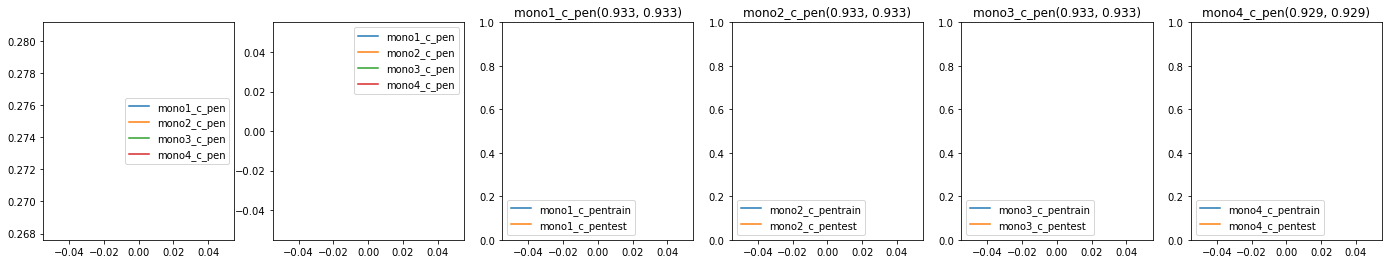

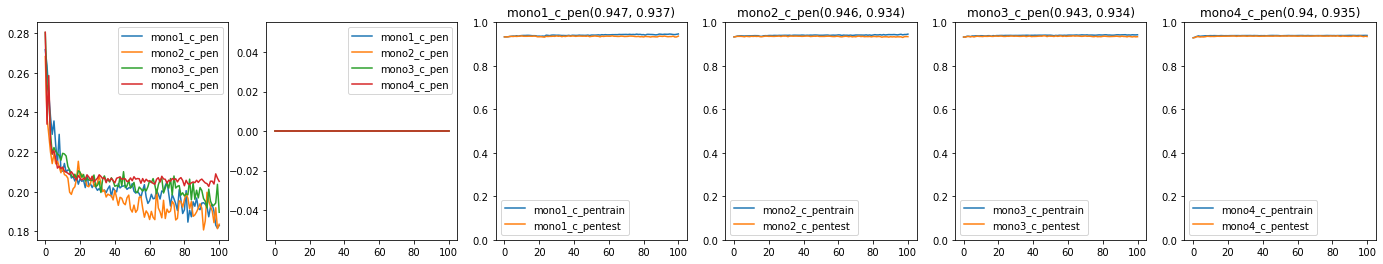

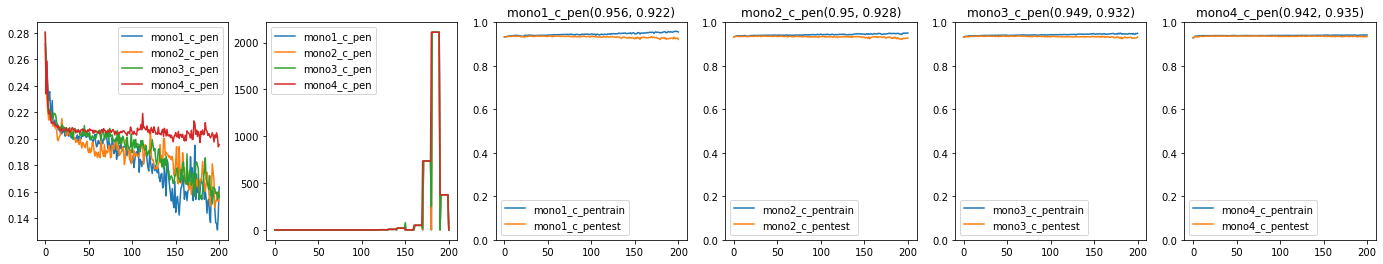

In [158]:
bs = 500 #50
weight = 0
accuracy_test = 0
accuracy = 0

data.requires_grad = True
data2= torch.rand(*data.shape,device="cuda")
data2.requires_grad = True

vio=0

for it in range(201):
    
    for m, (name, model) in enumerate(models.items()):
        
        optim = optims[name]
        
        for i in range(40):
            data_ = data[i*bs:(i+1)*bs]
            quadrature="clenshaw" if "c" in name else "gaussian"
            output, grad = model(data[i*bs:(i+1)*bs], return_grad=True, quadrature=quadrature)
            score  = output.view(-1)
            probs = sigmoid(score)
            loss = criterion(probs, target[i*bs:(i+1)*bs])
            if "pen" in name:
                if model.d>0:
                    loss += 1.0 * model.penalty(*grad, X=data_[:,:model.d])

            optim.zero_grad()
            loss.backward()
            optim.step()
            
        with torch.no_grad(): 
            score_test = model(data_test).view(-1)
            predict_test = (score_test>0).int()
            accuracy_test = (target_test==predict_test).float().mean().item()

            score = model(data).view(-1)
            predict = (score>0).int()
            accuracy = (target==predict).float().mean().item()
            recentest.update({name:(accuracy,accuracy_test)})
            
        if it%10 ==0:
            for i in range(40):
                data_ = data2[i*bs:(i+1)*bs]
                out= model(data_,return_grad=False)
                los = out.sum()
                los.backward()
            violation = data2.grad.data.clone()*0

            for j in range(len(model.mon)):
                violation[:,j] = (data2.grad.data[:,j].sign()!=np.sign(model.mon[j]))

            vio = violation.sum(dim=1).clip(max = 1).sum().item()
            data2.grad.data.zero_() 
        
        stats[name] = stats[name].append({"loss":min(loss.item(),100),
                                          "accu_train":accuracy,
                                          "accu_test":accuracy_test,
                                          "violations":vio,
                                         }, ignore_index=True) 
    if it%100 == 0: 
        fig, axis = plt.subplots(1,6, figsize = (24, 4))
        for m, (name, model) in enumerate(models.items()):
            stats[name]["loss"].plot(ax= axis[0],label = name)
            stats[name]["violations"].plot(ax= axis[1],label = name)
        
            stats[name]["accu_train"].plot(ax= axis[m+2],label = name+"train")
            stats[name]["accu_test"].plot(ax= axis[m+2],label = name+"test")
            
        for i in range(6):
            axis[i].legend()
            if i<2: continue
            axis[i].set_ylim((0,1))
            accuracy , accuracy_test = recentest[titles[i]]
            axis[i].set_title(titles[i]+str((round(accuracy,3),round(accuracy_test,3))))
            
        plt.show()

In [218]:
for m, (name, model) in enumerate(models.items()):
    torch.save(model.state_dict(), F"./data_models/{name}.md")
torch.save(stats,"./data_models/stats.dat")
#load:
#model.load_state_dict(torch.load(path), map_location="cuda")



In [159]:
cm_train={}
cm_test={}
acc_train={}
acc_test={}
with torch.no_grad():
    for m, (name, model) in enumerate(models.items()):
        quadrature="clenshaw" if "c" in name else "gaussian"
        pred_train = []
        for i in range(40):
            data_ = data[i*bs:(i+1)*bs]
            output= model(data_, return_grad=False, quadrature=quadrature)
            pred_train.append((output.view(-1)>0).int())
            
        pred_train = torch.cat(pred_train)
        acc_train.update({name: (pred_train==target).sum().float().item()/len(target)})

        score_test = model(data_test).view(-1)
        pred_test = (score_test>0).int()
        acc_test.update({name: (pred_test==target_test).sum().float().item()/len(target_test)})
        cm_train.update({name:confusion_matrix(Y_train, pred_train.cpu().numpy(),labels=[1,0])})
        cm_test.update({name:confusion_matrix(Y_test, pred_test.cpu().numpy(),labels=[1,0])})

In [200]:
acc_test

{'mono1_c_pen': 0.9216666666666666,
 'mono2_c_pen': 0.9276666666666666,
 'mono3_c_pen': 0.9323333333333333,
 'mono4_c_pen': 0.935}

In [201]:
stat_train={}
stat_test={}

for name, mat in cm_train.items():
    stat_train.update({name:measure(mat)})
    stat_train[name].update({"acc":acc_train[name]})
for name, mat in cm_test.items():
    stat_test.update({name:measure(mat)})
    stat_test[name].update({"acc":acc_test[name]})    

In [202]:
df_boost = pd.DataFrame(stat_boost)
df_boost

train       test  imbalance_train  imbalance_test
recall      0.499691   0.323651         0.911056        0.634855
precision   0.957396   0.696429         0.465300        0.323467
f1          0.656656   0.441926         0.615995        0.428571
acc        95.770000  93.433333         0.908050        0.864000

In [203]:
df_train = pd.DataFrame(stat_train)
df_train["boost"] = df_boost["train"]
df_train["im_boost"] = df_boost["imbalance_train"]
df_train

mono1_c_pen  mono2_c_pen  mono3_c_pen  mono4_c_pen      boost  \
recall        0.586164     0.510809     0.491044     0.359481   0.499691   
precision     0.819516     0.805258     0.810398     0.822034   0.957396   
f1            0.683471     0.625094     0.611538     0.500215   0.656656   
acc           0.956050     0.950400     0.949500     0.941850  95.770000   

           im_boost  
recall     0.911056  
precision  0.465300  
f1         0.615995  
acc        0.908050

In [204]:
df_test = pd.DataFrame(stat_test)
df_test["boost"] = df_boost["test"]
df_test["im_boost"] = df_boost["imbalance_test"]
df_test

mono1_c_pen  mono2_c_pen  mono3_c_pen  mono4_c_pen      boost  \
recall        0.369295     0.352697     0.390041     0.315353   0.323651   
precision     0.517442     0.582192     0.626667     0.716981   0.696429   
f1            0.430993     0.439276     0.480818     0.438040   0.441926   
acc           0.921667     0.927667     0.932333     0.935000  93.433333   

           im_boost  
recall     0.634855  
precision  0.323467  
f1         0.428571  
acc        0.864000

In [217]:
data_test.requires_grad = True

for m, (name, model) in enumerate(models.items()):
    bs2 = 100
    
    #data.zero_grad()
    F =0
    N = 0
    for i in range(30):
        data_ = data_test[i*bs2:(i+1)*bs2]
        out= model(data_,return_grad=False)
        loss = out.sum()
        loss.backward()
    violation = data_test.grad.data.clone()*0
    data.grad.data.zero_() 
    for j in range(len(model.mon)):
        violation[:,j] = (data_test.grad.data[:,j].sign()!=np.sign(model.mon[j]))
    print(name, violation.sum())
    print(name, violation.sum(dim=0)/violation.shape[0])
    
    data_test.grad.data.zero_() 

mono1_c_pen tensor(0., device='cuda:0')
mono1_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono2_c_pen tensor(0., device='cuda:0')
mono2_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono3_c_pen tensor(0., device='cuda:0')
mono3_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono4_c_pen tensor(0., device='cuda:0')
mono4_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


In [208]:
for m, (name, model) in enumerate(models.items()):

    data.grad.data.zero_() 
    #data.zero_grad()
    F =0
    N = 0
    for i in range(40):
        data_ = data[i*bs:(i+1)*bs]
        out= model(data_,return_grad=False)
        loss = out.sum()
        loss.backward()
    violation = data.grad.data.clone()*0
    data.grad.data.zero_() 
    for j in range(len(model.mon)):
        violation[:,j] = (data.grad.data[:,j].sign()!=np.sign(model.mon[j]))
    print(name, violation.sum())
    print(name, violation.sum(dim=0)/violation.shape[0])

mono1_c_pen tensor(0., device='cuda:0')
mono1_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono2_c_pen tensor(100000., device='cuda:0')
mono2_c_pen tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono3_c_pen tensor(140000., device='cuda:0')
mono3_c_pen tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono4_c_pen tensor(220000., device='cuda:0')
mono4_c_pen tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


In [209]:
data2= torch.rand(*data.shape,device="cuda")
data2.requires_grad = True

for m, (name, model) in enumerate(models.items()):

    
    for i in range(40):
        data_ = data2[i*bs:(i+1)*bs]
        out= model(data_,return_grad=False)
        loss = out.sum()
        loss.backward()
    violation = data2.grad.data.clone()*0

    for j in range(len(model.mon)):
        violation[:,j] = (data2.grad.data[:,j].sign()!=np.sign(model.mon[j]))
    print(name, violation.sum())
    print(name, violation.sum(dim=0)/violation.shape[0])
    data2.grad.data.zero_() 


mono1_c_pen tensor(0., device='cuda:0')
mono1_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono2_c_pen tensor(0., device='cuda:0')
mono2_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono3_c_pen tensor(0., device='cuda:0')
mono3_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
mono4_c_pen tensor(0., device='cuda:0')
mono4_c_pen tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


In [211]:
#auc_pairs={}
with torch.no_grad():
    for m, (name, model) in enumerate(models.items()):
        out= model(data_test,return_grad=False)
        y_scores = 1/(1+(-out).exp())
        fpr, tpr, _ = roc_curve(Y_test, y_scores.cpu())
        roc_auc = auc(fpr, tpr)
        auc_pairs.update({name: (fpr, tpr, roc_auc) })
        
        
        out= model(data,return_grad=False)
        y_scores = 1/(1+(-out).exp())
        fpr, tpr, _ = roc_curve(Y_train, y_scores.cpu())
        roc_auc = auc(fpr, tpr)
        auc_pairs_train.update({name: (fpr, tpr, roc_auc) })

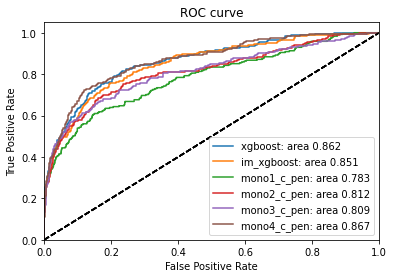

In [212]:
plot_rocs(auc_pairs)

In [214]:
plot_rocs(auc_pairs_train)